In [ ]:
from GT import get_dataset
import matplotlib.pyplot as plt
from GT import SGGTM
import json
import torch
import numpy as np
import os
import seaborn as sns
from tsl.datasets import AirQuality
from Notebooks.Eval.VisualEval import visualization, plot_boxplots_means, plot_histograms_means

DATASET_NAME = 'AirQuality'
MODEL_NAME= 'SGGTMAirQ'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [34]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [35]:
# Model Parameters 100 hidden
hidden_size = 64
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0.1
bidirectional = True
mixture_dim = 28
train_from_checkpoint = False

max_size = 8736//4

dataset = AirQuality(small=True, impute_nans=True)


adj = dataset.get_connectivity(**{'method': 'distance',
    'threshold': 0.1,
    'include_self': True,
    'layout': 'edge_index'
})

edge_index = torch.tensor(adj[0]).to(torch.int64)
edge_weight = torch.tensor(adj[1]).to(torch.float)

exo = dataset.datetime_encoded('day').values

dataset = dataset.dataframe()[:max_size]
exo = exo[:max_size]

## Dataset

In [36]:
# Dataset Split\
Train, Validation, Test = get_dataset('AirQuality', dataset, 168)

# Train[..., 0] = Train[..., 5]

train_data = Train
train_data = torch.Tensor(train_data)
exo_var = torch.Tensor(exo).reshape(train_data.shape[0], train_data.shape[1], 2)
# exo_var = []

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)
exo_size = 2
# exo_var = (exo_var - exo_var.min()) / (exo_var.max() - exo_var.min())  

AirQuality DATA
Original Dataset: 	39
Train Split: 		13 	(70%)
Validation Split: 	13 	(20%)
Test Split: 		13 	(10%)


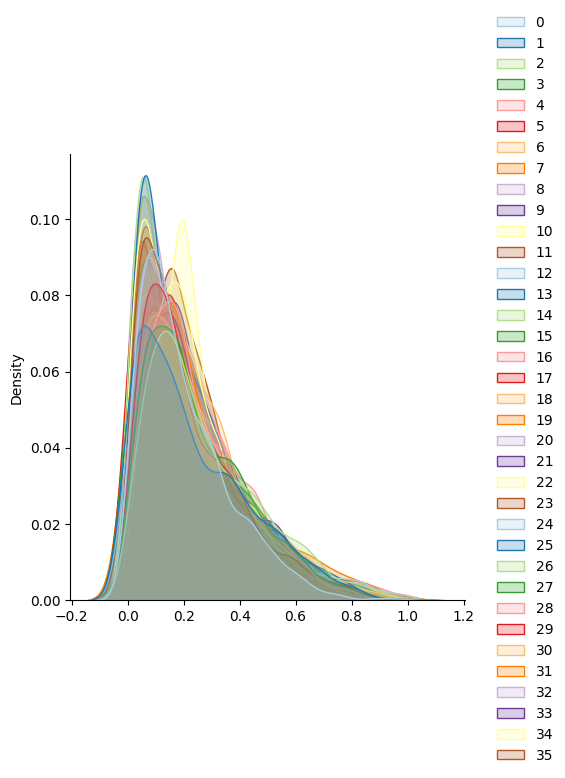

In [37]:
sns.displot(train_data.view(train_data.shape[0]*train_data.shape[1], train_data.shape[2]), fill=True, kind='kde', palette='Paired')
plt.show()

## Model Train

In [38]:
# Model Train
model = SGGTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, edge_index, edge_weight, exo_size)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, exo_var, batch_size=1, window=23, horizon=1, epochs=100)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_43085/2800422451.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

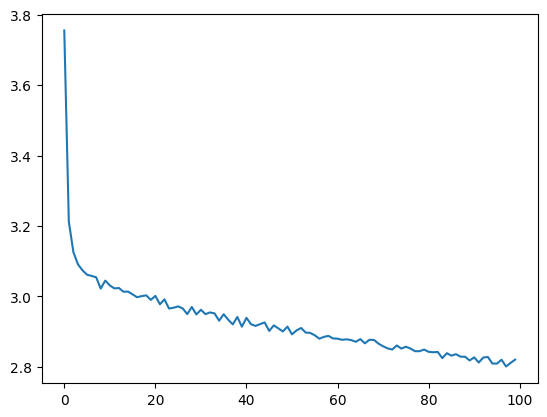

<Figure size 640x480 with 0 Axes>

In [39]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

# Model Eval


In [40]:
exo_var = torch.cat([exo_var, exo_var, exo_var, exo_var, exo_var, exo_var, exo_var, exo_var], dim=0)

In [41]:
output = model.generate_step(shape=(50, 168, 36), exo_var=exo_var.view(exo_var.shape[0]*exo_var.shape[1], exo_var.shape[2])[:9550].view(50, 191, exo_var.shape[2]), window = 23, horizon=1)
prediction = model.predict_step(data=train_data[0:10], exo_var=exo_var[:10], steps=168)
prediction2 = model.predict_step(torch.tensor(output[:10]), exo_var[:10], steps=168)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 168/168 [00:18<00:00,  9.10it/s]


In [ ]:
def plot_dist(datasets, kind='kde'):
    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True, sharex=False)
    if kind == 'box':
        plot_ = sns.boxplot
    elif kind == 'ecdf':
        plot_ = sns.ecdfplot
    elif kind == 'kde':
        plot_ = sns.kdeplot
    else:
        plot_ = sns.histplot

    reshaped_output = {}
    for key, gen in datasets.items():
        # Reshape the data to combine samples and time steps (flatten them)
        reshaped_output[key] = gen.reshape(gen.shape[0] * gen.shape[1], gen.shape[2])
        
    # Plot KDE for each feature (assuming output has 3 features)
    for i, item in zip(range(0, len(reshaped_output)), reshaped_output.items()):
        k, data = item
        if kind == 'kde':
            plot_(data, ax=ax[i], palette='Paired', fill=True, legend=False)
        else:
            plot_(data, ax=ax[i], palette='Paired')
        ax[i].set_title(f'Distributions for dataset {k}')

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_dist({'Generated': output, 'Predicted': prediction, 'Prediction on Gen': prediction2, 'Original': train_data}, 'kde')

AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

Error in callback <function _draw_all_if_interactive at 0x31e1c2340> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_43085/658949032.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.reshape(train_data.shape[0]*train_data.shape[1], -1))
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_43085/658949032.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

<Axes: ylabel='Density'>

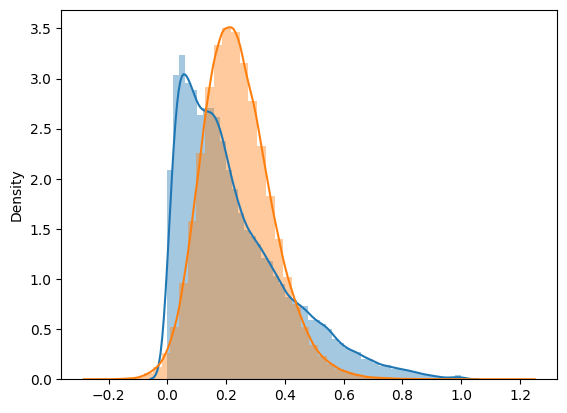

In [43]:
sns.distplot(train_data.reshape(train_data.shape[0]*train_data.shape[1], -1))
sns.distplot(output.reshape(output.shape[0]*output.shape[1], -1))

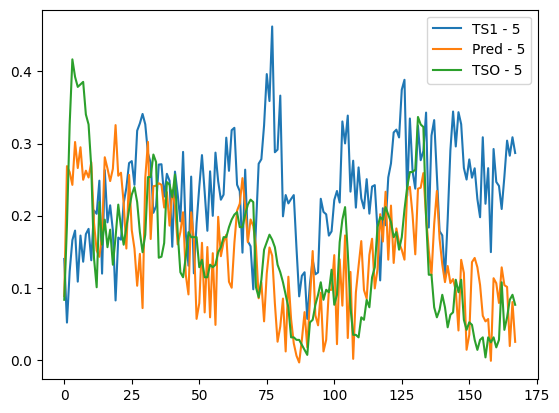

In [44]:
plt.plot(output[3, :, 5], label='TS1 - 5') 

plt.plot(prediction[1, :, 5], label='Pred - 5')

plt.plot(train_data[1, :, 5], label='TSO - 5')
plt.legend()
plt.show()

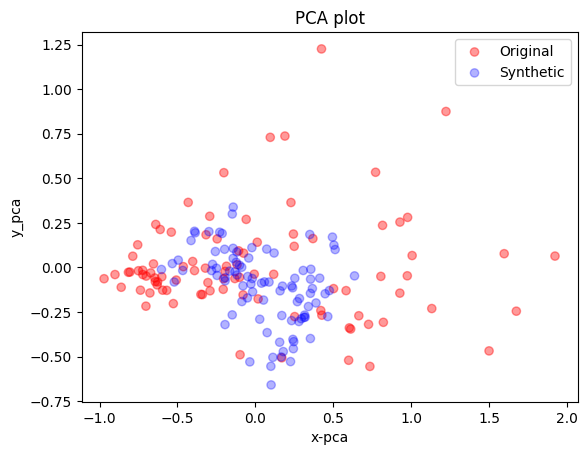

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 182 samples in 0.000s...
[t-SNE] Computed neighbors for 182 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 182 / 182
[t-SNE] Mean sigma: 0.217118
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.205566
[t-SNE] KL divergence after 300 iterations: 0.185870


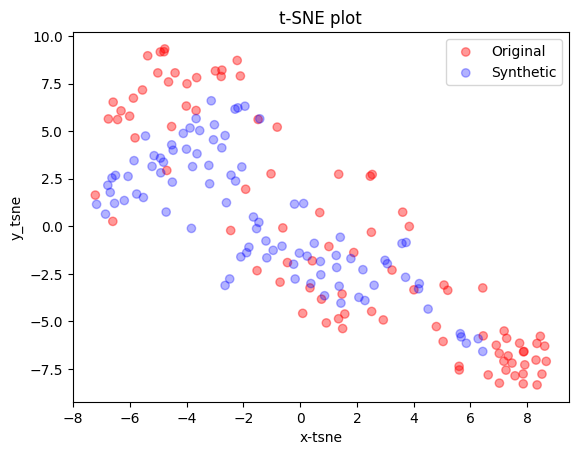

In [45]:
mlen = train_data.shape[0]*train_data.shape[1] // 24
olen =  output.shape[0]*output.shape[1] // 24
visualization(train_data.reshape(mlen, 24, 36)[:olen], torch.Tensor(output).reshape(olen, 24, 36), 'pca')
visualization(train_data.reshape(mlen, 24, 36)[:olen], torch.Tensor(output).reshape(olen, 24, 36), 'tsne')

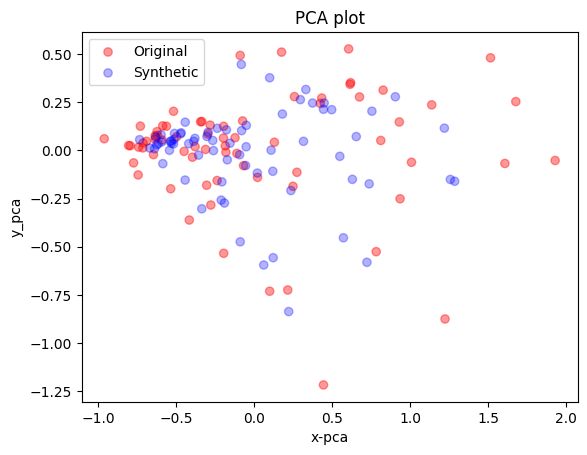

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.000s...
[t-SNE] Computed neighbors for 140 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 0.245804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.129253
[t-SNE] KL divergence after 300 iterations: 0.160262


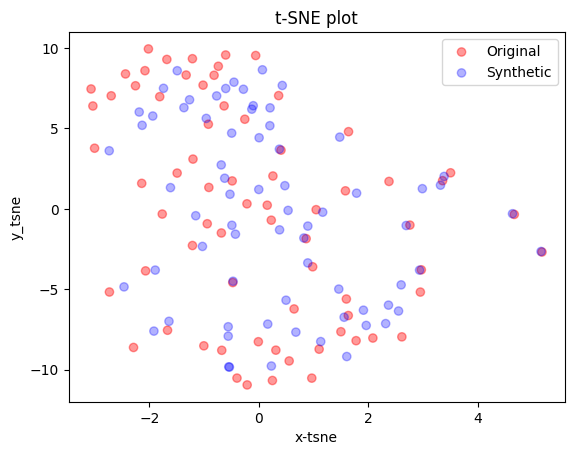

In [46]:
plen =  prediction.shape[0]*output.shape[1] // 24
visualization(train_data.reshape(mlen, 24, 36)[:plen], torch.Tensor(prediction).reshape(plen, 24, 36), 'pca')
visualization(train_data.reshape(mlen, 24, 36)[:plen], torch.Tensor(prediction).reshape(plen, 24, 36), 'tsne')

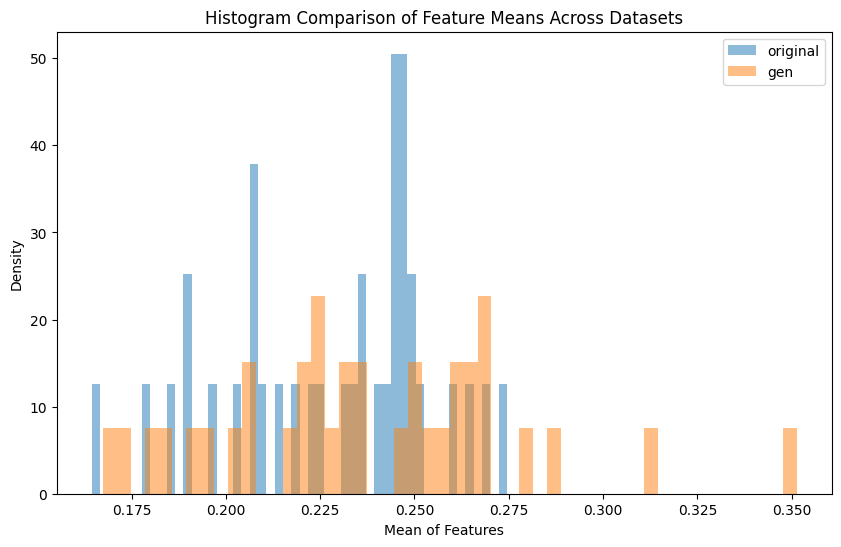

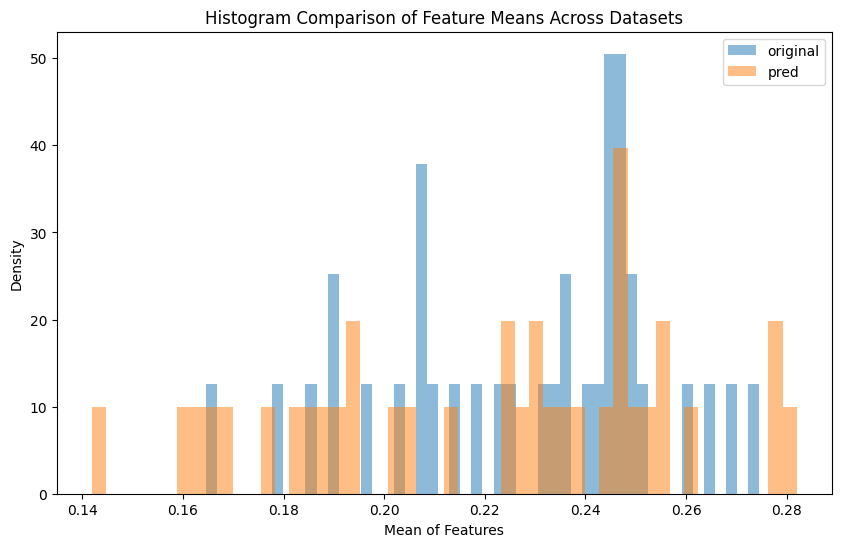

In [47]:
plot_histograms_means(('original', np.array(train_data.reshape(mlen*24, 36))), ('gen', output.reshape(olen*24, 36)))
plot_histograms_means(('original', np.array(train_data.reshape(mlen*24, 36))), ('pred', prediction.reshape(plen*24, 36)))

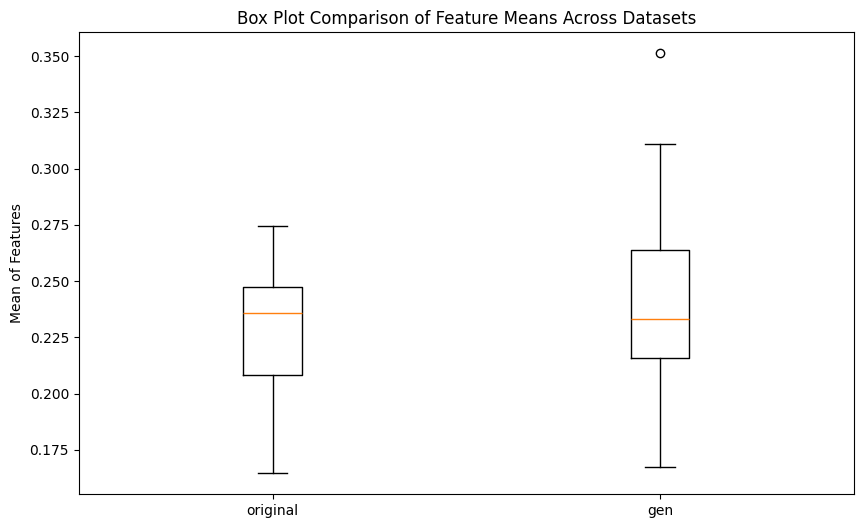

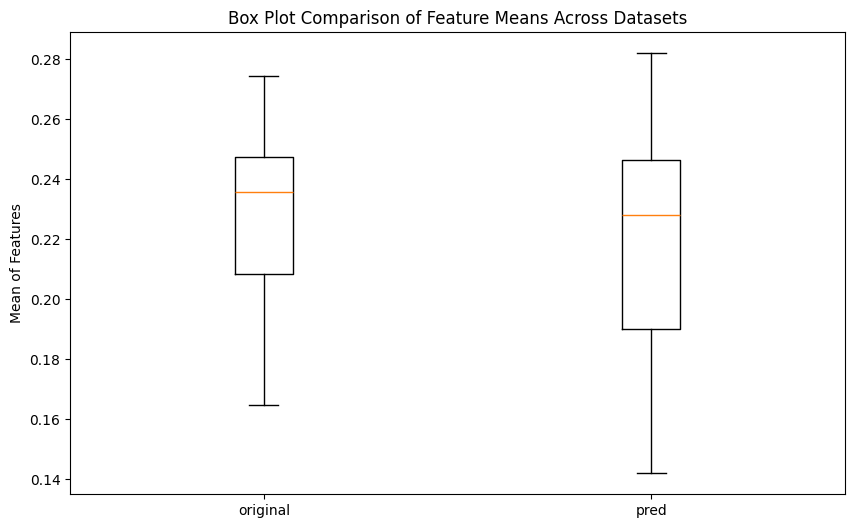

In [48]:
plot_boxplots_means(('original', np.array(train_data.reshape(mlen*24, 36))), ('gen', output.reshape(olen*24, 36)))
plot_boxplots_means(('original', np.array(train_data.reshape(mlen*24, 36))), ('pred', prediction.reshape(plen*24, 36)))